# SRCNN

In [41]:
import glob
import h5py
import numpy as np
import PIL.Image as pil_image
from tqdm import tqdm
import matplotlib.pyplot as plt

# 转换数据集
train_imgs_dir = "./T91-train"
train_h5_file = h5py.File("./datasets/train.h5", 'w')
scale = 4  # 下采样倍数
f_sub = 33
stride = 14  # 划分图片  the 91-image dataset can be decomposed into 24,800 sub-images

lr_subs = []  # 小图片
hr_subs = []

for train_img_path in tqdm(sorted(glob.glob('{}/*'.format(train_imgs_dir))), total=91):
    hr = pil_image.open(train_img_path).convert('RGB')
    hr_width = (hr.width // scale) * scale
    hr_height = (hr.height // scale) * scale
    hr = hr.resize((hr_width,hr_height), resample=pil_image.Resampling.BICUBIC)  # 原高分辨率图像(标签)
    lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.Resampling.BICUBIC)  # 双三线性插值下采样(无高斯模糊)
    lr = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.Resampling.BICUBIC)  # 双三线性插值上采样(训练样本，size和hr一样)
    hr = np.array(hr).astype(np.float32)
    lr = np.array(lr).astype(np.float32)
    
    for i in range(0, lr.shape[0]-f_sub+1, stride):
        for j in range(0, lr.shape[1]-f_sub+1, stride):
            lr_subs.append(lr[i:i+f_sub,j:j+f_sub,:])
            hr_subs.append(hr[i:i+f_sub,j:j+f_sub,:])
            
lr_subs = np.array(lr_subs)
hr_subs = np.array(hr_subs)
print(f"子图数目:{hr_subs.shape[0]}")
train_h5_file.create_dataset('lr', data=lr_subs)
train_h5_file.create_dataset('hr', data=hr_subs)
train_h5_file.close()

100%|████████████████████████| 91/91 [00:00<00:00, 177.66it/s]


子图数目:21772


In [6]:
import h5py
import numpy as np
from torch.utils.data import Dataset

class TrainDataset(Dataset):
    def __init__(self, h5_file):
        super(TrainDataset, self).__init__()
        self.h5_file = h5_file
        
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as f:
            item = np.transpose(f['lr'][idx] / 255., (2,0,1))
            label = np.transpose(f['hr'][idx] / 255., (2,0,1))
        return item, label
            
    def __len__(self):
        with h5py.File(self.h5_file, 'r') as f:
            return len(f['lr'])

In [7]:
from torch import nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN,self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=9, padding=9//2),
            nn.ReLU(),
            nn.Conv2d(64, 32, 5, padding=5//2),
            nn.ReLU(),
            nn.Conv2d(32, 3, 5, padding=5//2)
        )
        
    def forward(self, x):
        y = self.net(x)
        return y 

100%|███████████████████████| 200/200 [12:45<00:00,  3.83s/it]


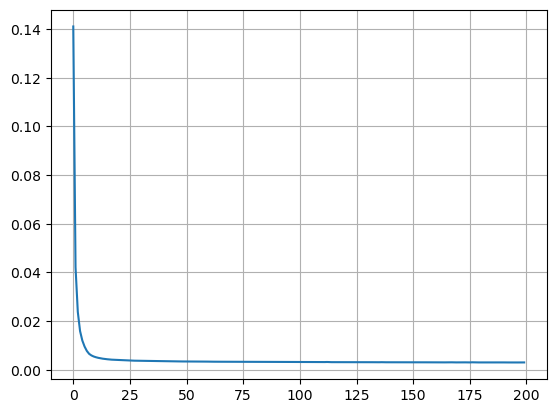

In [12]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lr = 1e-4
epochs = 200
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
ds_train = TrainDataset("./datasets/train.h5")
dl_train = DataLoader(ds_train, batch_size=1024, shuffle=True, num_workers=4, drop_last=True)

losses = []
for epoch in tqdm(range(epochs),total=epochs):
    epoch_losses = []
    model.train()
    for features, labels in dl_train:
        features = features.to(device)
        labels = labels.to(device)
        preds = model(features)
        loss = criterion(preds, labels)
        epoch_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(torch.mean(torch.FloatTensor(epoch_losses)).item())
plt.plot(range(epochs), losses)
plt.grid(True)
plt.show()
torch.save(model.state_dict(), os.path.join('./model.pkl'))

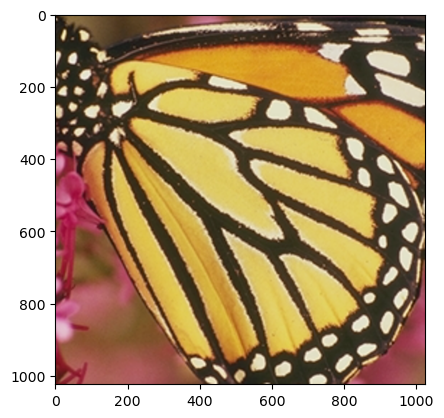

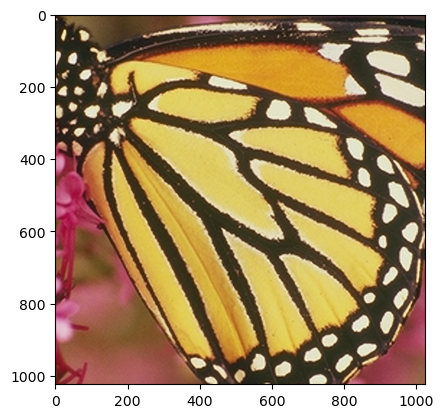

In [44]:
import PIL.Image as pil_image

scale = 4
test_img = pil_image.open('butterfly.png').convert('RGB')
test_img = test_img.resize((test_img.width * scale, test_img.height * scale), resample=pil_image.Resampling.BICUBIC)
test_img.save('./BICUBIC_image.png')
plt.imshow(test_img)
plt.show()
test_img = np.array(test_img).astype(np.float32)
input = torch.tensor(np.transpose(test_img / 255., (2,0,1)), device=device).unsqueeze(0)  # [B, C, H, W]
model.eval()
with torch.no_grad():
    output = model(input).clamp(0.0, 1.0)
output = output.cpu().data.squeeze().permute(1,2,0).numpy()
plt.imshow(output)
plt.show()
SR = (output * 255.).astype(np.uint8)
out_Img = pil_image.fromarray(SR)
out_Img.save('./SR_image.png')